# Pickle Y1 Xi files for Barry
This notebook includes code to ingest all the Y1 blinded data files. Barry has a strict set of data inputs, and everything gets pickled up into this format. This means the underlying clustering measurements etc., can be in any format.

Barry expects that you will read in/specify and pickle:
* The number of correlated datasets. **We set n_data == 1 below, but this would be 2 if we were providing i.e., NGC+SGC data vectors and wanted to consider different bias or polynomials for each cap**
* Pre and post-recon data power spectrum with 5 multipoles (some multipoles can be set to zero if they are not required/measured). **Post-recon data currently set to None as it doesn't have the same redshift binning.**
* N pre and post-recon mock power spectra with 5 multipoles (some can be set to zero if they are not required/measured). **Mocks currently set to None as we don't have these yet**
* Pre and post-recon covariance matrices for the power spectra (some elements/blocks can be set to zero if they are not required/measured). **Pre-recon analytic used for both currently.**
* A fiducial cosmology. **I've assumed the DESI fiducial cosmology**
* A window function convolution/binning matrix (some elements/blocks can be set to the identify matrix if they are not required/measured), corresponding k-binning and integral constraint. Only needed for power spectra.
* A compression matrix to convert the 3 even multipoles to 5 even+odd (can be given as a block identity matrix if you are not measuring odd multipoles). Only needed for power spectra.

Correlation functions are similar but a little simpler (only 3 multipoles, and no window function stuff).

In [1]:
# Import the necessary packages, set up the fiducial cosmology and save the DESI template
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from cosmoprimo import PowerSpectrumBAOFilter
from cosmoprimo.fiducial import DESI
from pypower import BaseMatrix, CatalogFFTPower, CatalogFFTCorr, PowerSpectrumMultipoles, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix, PowerSpectrumOddWideAngleMatrix, setup_logging
from pycorr import TwoPointCorrelationFunction, project_to_multipoles

cosmo = DESI()
print(cosmo["Omega_b"]*cosmo["h"]**2, cosmo["Omega_cdm"]*cosmo["h"]**2, cosmo["Omega_m"]*cosmo["h"]**2 - cosmo["Omega_b"]*cosmo["h"]**2)
print(cosmo["A_s"], cosmo["n_s"], cosmo["tau_reio"])
print(np.sum(cosmo["m_ncdm"]))

# Save the default DESI template to a file
k_min = 1e-4
k_max = 5
k_num = 2000
kl = np.logspace(np.log(k_min), np.log(k_max), k_num, base=np.e)
pkz = cosmo.get_fourier().pk_interpolator()
pk = pkz.to_1d(z=0)
pkv = pk(kl)
pknow = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
pksmv = pknow(kl)
#np.savetxt("./DESI_Pk_template.dat", np.c_[kl, pksmv, pkv/pksmv - 1.0],  fmt="%g %g %g", header="k     pk_smooth     pk_ratio")

0.02237 0.12 0.1206441345126498
2.083e-09 0.9649 0.0544
0.05999991930682943


# Correlation function routines

In [4]:
# Useful utility function to collate some Xi data
def collect_xi_data(pre_files, post_files, pre_mock_files, post_mock_files, pre_cov_files, post_cov_files, pre_files_name, post_files_name, pre_cov_name, post_cov_name, zs, version, reconsmooth, rpcut, imaging):

    pre_data = get_xi2(pre_files, pre_files_name, rpcut, imaging) if pre_files is not None else None
    post_data = get_xi2(post_files, post_files_name, rpcut, imaging) if post_files is not None else None
    
    pre_mocks = get_xi2_mock(pre_mock_files, pre_files_name, rpcut, imaging) if pre_mock_files is not None else None
    post_mocks = get_xi2_mock(post_mock_files, post_files_name, rpcut, imaging) if post_mock_files is not None else None
    #pre_mocks, post_mocks = None, None
    
    pre_cov = get_xi_cov(pre_cov_files, pre_cov_name, rpcut, imaging) if pre_cov_name is not None else None
    post_cov = get_xi_cov(post_cov_files, post_cov_name, rpcut, imaging) if post_cov_name is not None else None
    
    rp = f" {imaging} rpcut2.5" if rpcut else f" {imaging}" 
    
    split = {
        "n_data": 1,
        "pre-recon data": pre_data,
        "pre-recon cov": pre_cov,
        "post-recon data": post_data,
        "post-recon cov": post_cov,
        "pre-recon mocks": pre_mocks,
        "post-recon mocks": post_mocks,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": (zs[1]+zs[0])/2.0,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": reconsmooth,
        },
        "name": "DESI Y1 BLIND " + f"v{version} sm{reconsmooth} " + pre_files_name + rp
    }
    
    with open(f"/global/cfs/cdirs/desi/users/chowlett/barry_inputs/DESI_Y1_BLIND_v{version}_sm{reconsmooth}_" + pre_files_name.lower() + ("_").join(rp.split(" ")) + "_xi.pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split

# Correlation function
def get_xi(loc, name, rpcut, imaging):
    
    rp = "_rpcut2.5" if rpcut else "" 
    nran = "nran5" if "MGrec" in name else "nran4"
    infile = loc + "xipoles_" + name + f"_{imaging}_lin4_njack0_{nran}_split20{rp}.txt"
    
    xi = pd.read_csv(infile, comment="#", skiprows=0, delim_whitespace=True, header=None, names=["s", "savg","xi0","xi2","xi4"])
    xi = xi.drop(xi[xi["s"] < 20.0].index)
    
    return [xi[["s","xi0","xi2","xi4"]]]

# Correlation function
def get_xi2(loc, name, rpcut, imaging):
    
    infile = loc + "allcounts_" + name + ".npy"
    
    result = TwoPointCorrelationFunction.load(infile)
    factor = 4
    rebinned = result[:(result.shape[0] // factor) * factor:factor]
    sep, xi = rebinned(ells=(0, 2, 4), return_sep=True, return_std=False)

    xis = pd.DataFrame({'s': sep, 'xi0': xi[0], 'xi2': xi[1], 'xi4': xi[2]})
    xis = xis.drop(xis[xis["s"] < 20.0].index)
    
    return [xis[["s","xi0","xi2","xi4"]]]

# Correlation function
def get_xi2_mock(loc, name, rpcut, imaging):
    
    nmocks = 1000
    
    firstloc = ("/").join(loc.split("/")[:-4]) if "recon_recsym" in loc else ("/").join(loc.split("/")[:-3])
    secondloc = ("/").join(loc.split("/")[-4:]) if "recon_recsym" in loc else ("/").join(loc.split("/")[-3:])
    
    xis = []
    for i in range(1,nmocks):
        infile = firstloc + f"/mock{i}/" + secondloc + "allcounts_" + name.replace("ELG_LOPnotqso","ELG_LOP") + ".npy"
        try:
            result = TwoPointCorrelationFunction.load(infile)
            factor = 4
            rebinned = result[:(result.shape[0] // factor) * factor:factor]
            sep, xi = rebinned(ells=(0, 2, 4), return_sep=True, return_std=False)

            xidf = pd.DataFrame({'s': sep, 'xi0': xi[0], 'xi2': xi[1], 'xi4': xi[2]})
            xidf = xidf.drop(xidf[xidf["s"] < 20.0].index)
            xis.append(xidf[["s","xi0","xi2","xi4"]])
        except:
            continue
            
    return xis

# Correlation function covariance matrix.
def get_xi_cov(loc, name, rpcut, imaging):

    s = "rescaled"
    infile = loc + "xi024_" + name.replace("sm30","sm20") + f"_{imaging}_lin4_s20-200_cov_RascalC_{s}.txt"    # No recon_sm30 cov for QSO yet
    
    cov = pd.read_csv(infile, comment="#", delim_whitespace=True, header=None).to_numpy()
    
    #plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))
    #plt.show()
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")

    return cov
    
# Plot the correlation function, for sanity checking
def plot_xi(split, pre=True, post=True):

    color = ["r", "b", "g"]
    ss = split["pre-recon data"][0]["s"]
    nmocks = len(split["pre-recon mocks"]) if split["pre-recon mocks"] is not None else 0
    label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
    
    if pre:
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * split["pre-recon data"][0][xi],
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["pre-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()
    if post:
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["post-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * split["post-recon data"][0][xi],
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["post-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()

# Grab all the various datasets!!
This will also plot the datasets, but this has been commented out in the GitHub version for

## Version 0.6

In [13]:
# The catalogue version
version = 0.6
rpcut = False             # Whether or not to include the rpcut
imaging = "default_FKP"   # What form of imaging systematics to use. Can be "default_FKP", "default_FKP_addSN", or "default_FKP_addRF"

# This is a dictionary of all the combinations of dataset that we have and their redshift bins.
tracers = {'BGS_BRIGHT-21.5': [[0.1, 0.4]], 
           'LRG': [[0.4, 0.6], [0.6, 0.8], [0.8, 1.1]], 
           'ELG_LOPnotqso': [[0.8, 1.1], [1.1, 1.6]],
           'QSO': [[0.8, 2.1]]}

# This dictionary specifies the particulars of how reconstruction was run on each tracer. First entry is smoothing scale, second is type of recon.
recon = {'BGS_BRIGHT-21.5': [15, "IFTrecsym"], 
         'LRG': [10, "IFTrecsym"], 
         'ELG_LOPnotqso': [10, "IFTrecsym"],
         'QSO': [20, "IFTrecsym"]}

# The different sky areas
caps = ["NGC", "SGC", "GCcomb"]

basepath = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v{version}/blinded/"
pre_cov_files = f"/global/cfs/cdirs/desi/users/mrash/RascalC/Y1/blinded/v{version}/"       
post_cov_files = f"/global/cfs/cdirs/desi/users/mrash/RascalC/Y1/blinded/v{version}/"

# Now loop over each tracer, redshift bin and cap and gather the files. First pre-recon
for t in tracers:
    for i, zs in enumerate(tracers[t]):
        for cap in caps:
            
            pre_files = basepath + f"/xi/smu/"
            post_files = basepath + f"/recon_sm{recon[t][0]}/xi/smu/"

            pre_name = f"{t}_{cap}_{zs[0]}_{zs[1]}"
            post_name = f"{t}_{recon[t][1]}_{cap}_{zs[0]}_{zs[1]}"
            pre_cov_name = pre_name
            post_cov_name = f"{t}_{recon[t][1]}_sm{recon[t][0]}_{cap}_{zs[0]}_{zs[1]}"
            
            data = collect_xi_data(pre_files, post_files, pre_cov_files, post_cov_files, pre_name, post_name, pre_cov_name, post_cov_name, zs, version, recon[t][0], rpcut, imaging)
            
            #plot_xi(data) # Plot the data to check things

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded//xi/smu/allcounts_BGS_BRIGHT-21.5_NGC_0.1_0.4.npy'

## Version 1

BGS_BRIGHT-21.5 [0.1, 0.4]


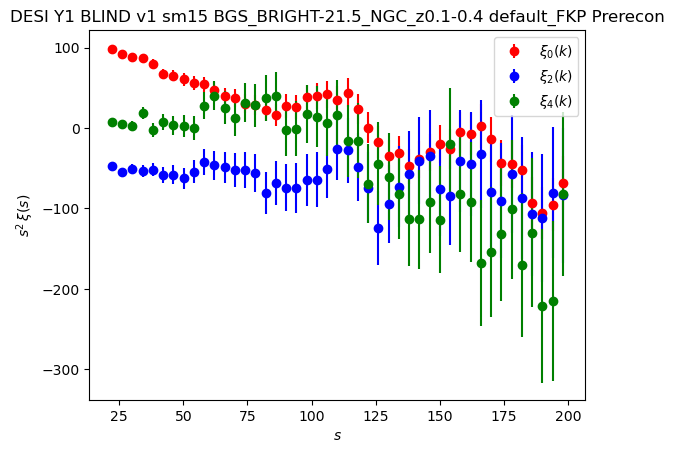

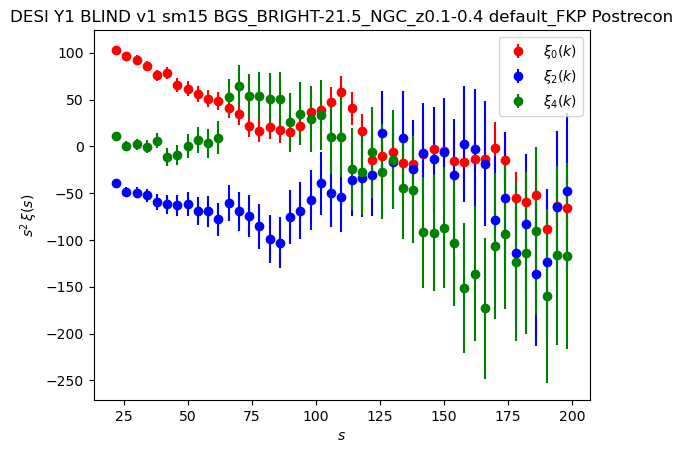

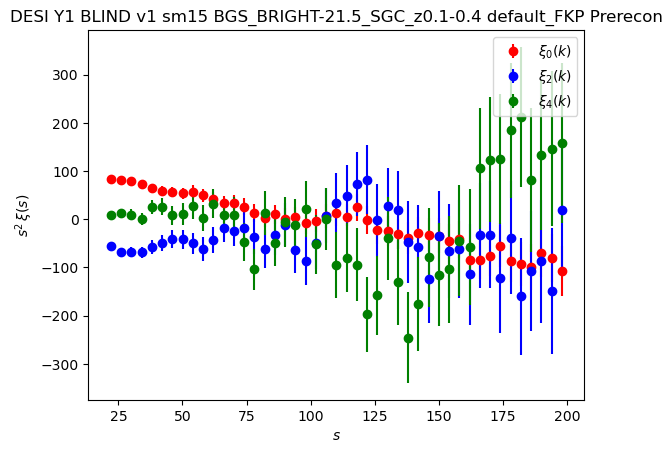

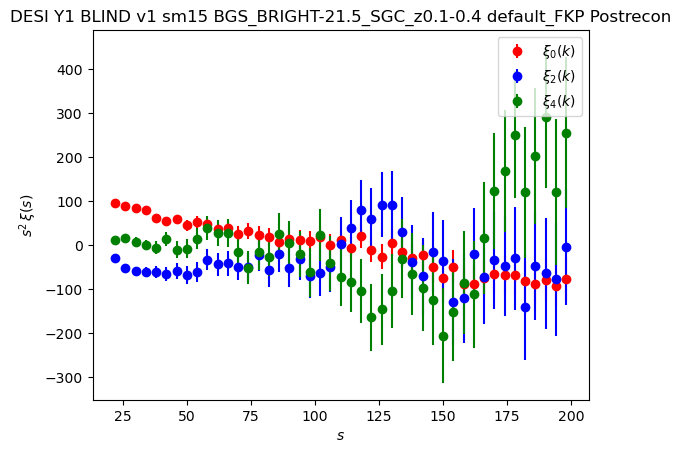

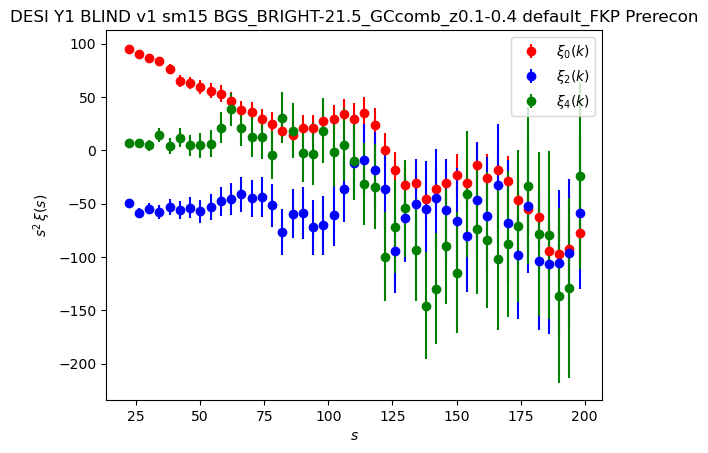

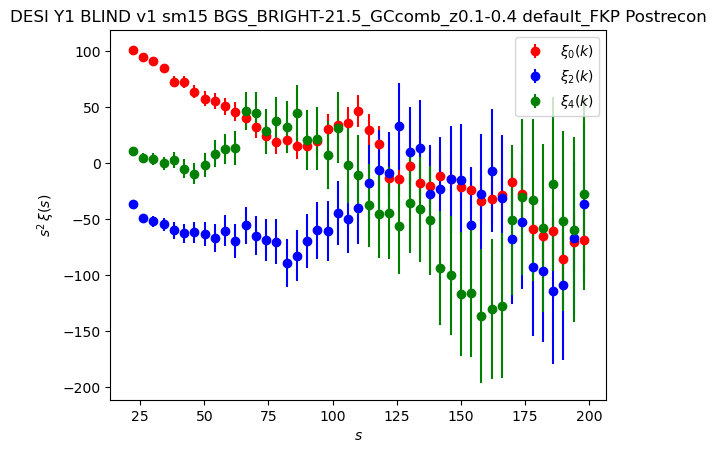

In [5]:
# The catalogue version
version = 1
rpcut = False             # Whether or not to include the rpcut
imaging = "default_FKP"   # What form of imaging systematics to use. Can be "default_FKP", "default_FKP_addSN", or "default_FKP_addRF"

# This is a dictionary of all the combinations of dataset that we have and their redshift bins.
tracers = {'BGS_BRIGHT-21.5': [[0.1, 0.4]], 
           #'LRG': [[0.4, 0.6], [0.6, 0.8], [0.8, 1.1]], 
           #'ELG_LOPnotqso': [[0.8, 1.1], [1.1, 1.6]],
           #'QSO': [[0.8, 2.1]]
            }

# This dictionary specifies the particulars of how reconstruction was run on each tracer. First entry is smoothing scale, second is type of recon.
recon = {'BGS_BRIGHT-21.5': [15, "IFTrecsym"], 
         'LRG': [10, "IFTrecsym"], 
         'ELG_LOPnotqso': [10, "IFTrecsym"],
         'QSO': [30, "IFTrecsym"]}

# The different sky areas
caps = ["NGC", "SGC", "GCcomb"]

basepath = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v{version}/blinded/desipipe/baseline_2pt"
basepath_mock = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v{version}/ffa/baseline_2pt"
pre_cov_files = f"/global/cfs/cdirs/desi/users/mrash/RascalC/Y1/blinded/v0.6/"       
post_cov_files = f"/global/cfs/cdirs/desi/users/mrash/RascalC/Y1/blinded/v0.6/"

# Now loop over each tracer, redshift bin and cap and gather the files. First pre-recon
for t in tracers:
    for i, zs in enumerate(tracers[t]):
        print(t, zs)
        for cap in caps:
            
            pre_files = basepath + f"/xi/smu/"
            post_files = basepath + f"/recon_recsym/xi/smu/"
            pre_mock_files = None if t == "BGS_BRIGHT-21.5" else basepath_mock + f"/xi/smu/"
            post_mock_files = None if t == "BGS_BRIGHT-21.5" else basepath_mock + f"/recon_recsym/xi/smu/"

            pre_name = f"{t}_{cap}_z{zs[0]}-{zs[1]}"
            post_name = f"{t}_{cap}_z{zs[0]}-{zs[1]}"
            pre_cov_name = f"{t}_{cap}_{zs[0]}_{zs[1]}"
            post_cov_name = f"{t}_{recon[t][1]}_sm{recon[t][0]}_{cap}_{zs[0]}_{zs[1]}"
            
            data = collect_xi_data(pre_files, post_files, pre_mock_files, post_mock_files, pre_cov_files, post_cov_files, pre_name, post_name, pre_cov_name, post_cov_name, zs, version, recon[t][0], rpcut, imaging)
            
            plot_xi(data) # Plot the data to check things

# Test we can load the datasets in Barry
This loads in the pickle file using the Barry routines, and then plots the data and a default model. Because I've set marg="full", it will automatically find the best-fit polynomial terms too when plotting, but not the BAO parameters. If this works, a full MCMC BAO fit should work.

In [26]:
import os
import sys
import pickle
import numpy as np

sys.path.append("../../../Barry/")     # Change this so that it points to where you have Barry installed
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4

for t in tracers:
    for i, zs in enumerate(tracers[t]):
        for cap in caps:
            for r in [None, "sym"]:
            
                rp = f"{imaging}_rpcut2.5" if rpcut else f"{imaging}"
                name = f"DESI_Y1_BLIND_v{version}_sm{recon[t][0]}_{t.lower()}_{cap.lower()}_{zs[0]}_{zs[1]}_{rp}_xi.pkl"
                dataset = CorrelationFunction_DESI_KP4(
                    recon=r,
                    fit_poles=[0, 2],
                    min_dist=52.0,
                    max_dist=150.0,
                    realisation='data',
                    num_mocks=1000,
                    reduce_cov_factor=1,
                    datafile=name,
                    data_location="./",
                )

                model = CorrBeutler2017(
                    recon=dataset.recon,
                    isotropic=dataset.isotropic,
                    marg="full",
                    poly_poles=dataset.fit_poles,
                    n_poly=[-2,-1,0],    # Standard polynomial terms for xi
                )

                model.set_data(dataset.get_data())
                print(f"{name} Worked!")
                #model.plot(model.get_param_dict(model.get_defaults()))

DESI_Y1_BLIND_v0.6_sm15_bgs_bright-21.5_ngc_0.1_0.4_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm15_bgs_bright-21.5_ngc_0.1_0.4_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm15_bgs_bright-21.5_sgc_0.1_0.4_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm15_bgs_bright-21.5_sgc_0.1_0.4_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm15_bgs_bright-21.5_gccomb_0.1_0.4_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm15_bgs_bright-21.5_gccomb_0.1_0.4_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm10_lrg_ngc_0.4_0.6_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm10_lrg_ngc_0.4_0.6_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm10_lrg_sgc_0.4_0.6_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm10_lrg_sgc_0.4_0.6_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm10_lrg_gccomb_0.4_0.6_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm10_lrg_gccomb_0.4_0.6_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm10_lrg_ngc_0.6_0.8_default_FKP_xi.pkl Worked!
DESI_Y1_BLIND_v0.6_sm10_lrg_ngc_0.6_0.8_defau